Simulated Weather Data (first 10 days):
   day         condition  temperature  humidity  rain  thunder
0    1  Partially cloudy         21.1      62.3     6    False
1    2             Clear         20.2      55.6     4     True
2    3  Partially cloudy         20.6      53.3     5    False
3    4             Clear         20.5      54.4     9    False
4    5             Clear         21.0      54.5     5    False
5    6  Partially cloudy         18.8      53.8     5    False
6    7             Clear         20.4      53.1     7    False
7    8  Partially cloudy         19.6      57.2    10    False
8    9             Clear         20.1      56.9     4     True
9   10             Clear         20.5      55.6     4    False


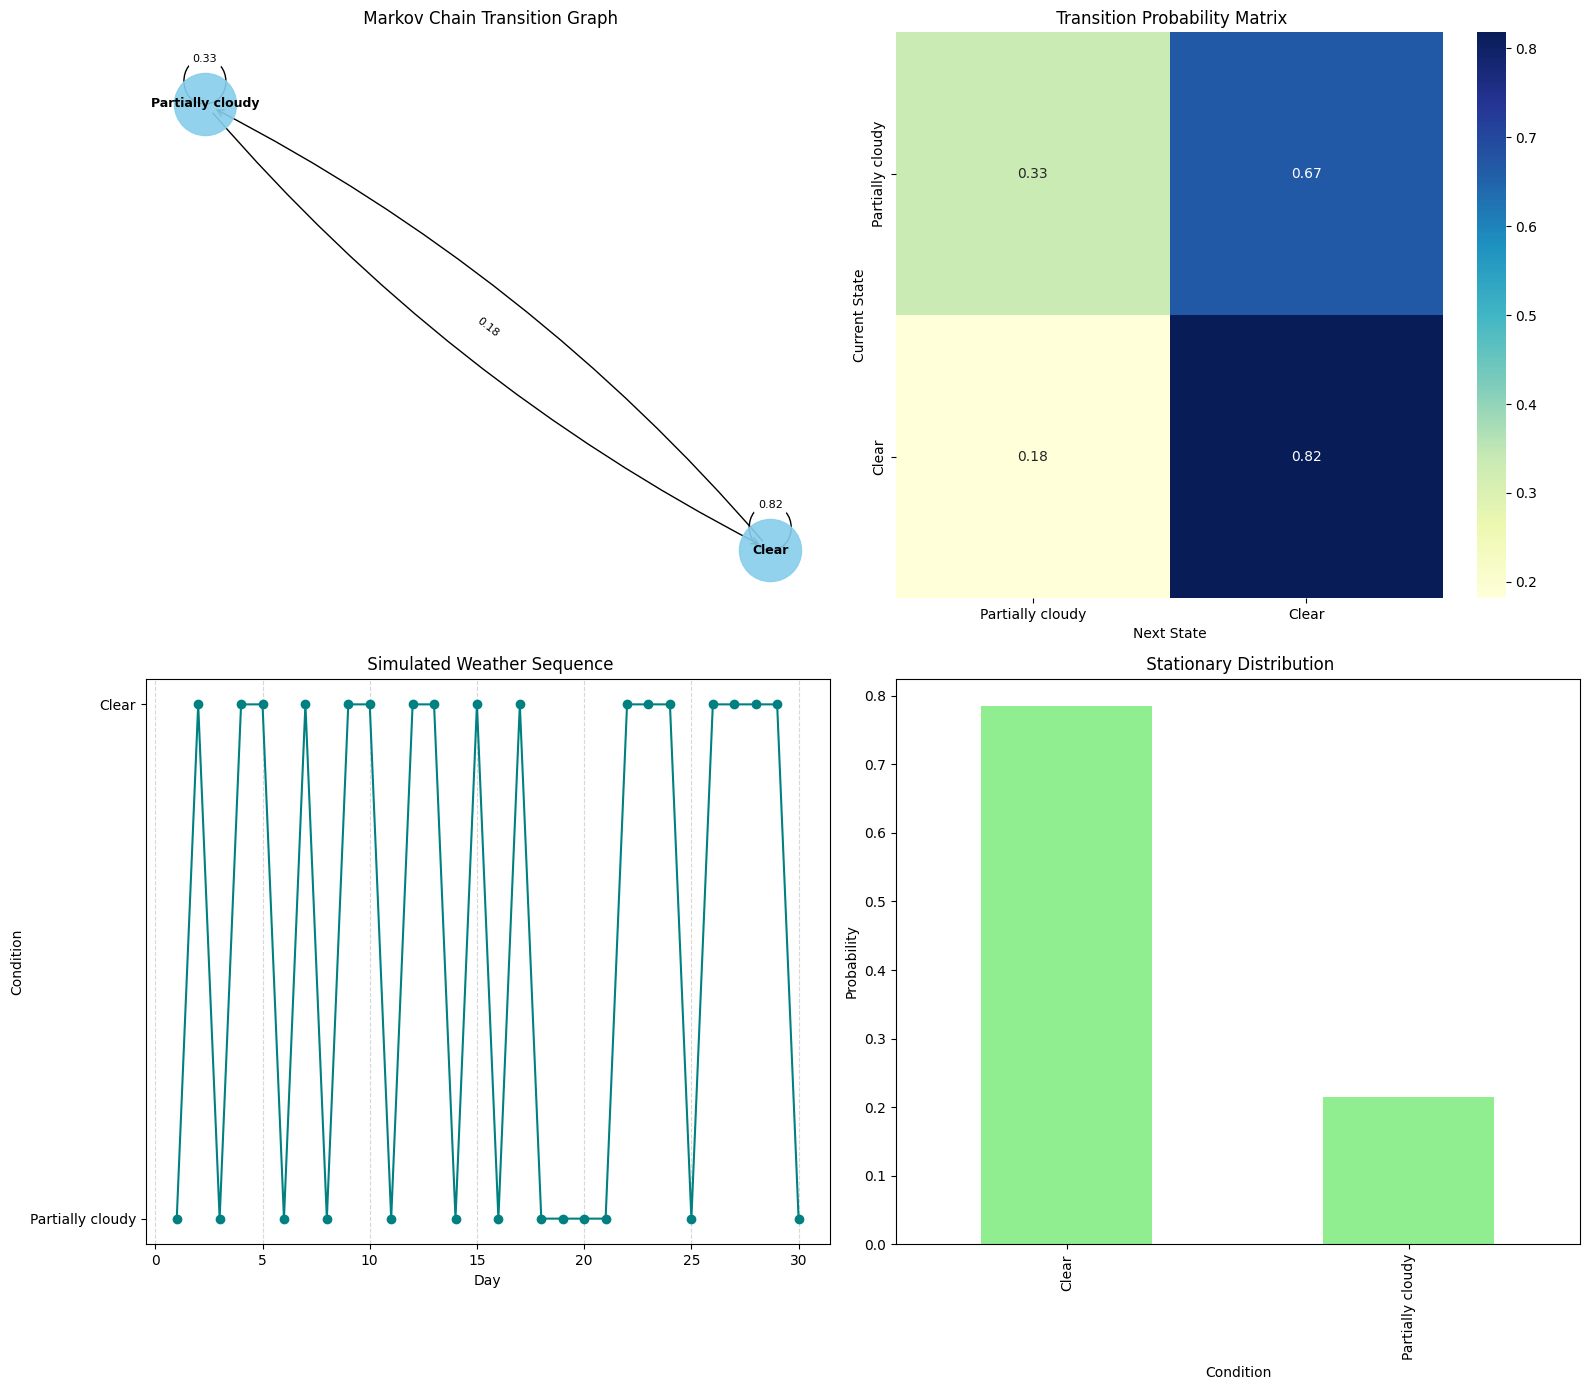

In [2]:
# -----------------------------
# 1️⃣ Import libraries
# -----------------------------
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# -----------------------------
# 2️⃣ Load dataset
# -----------------------------
df = pd.read_csv("dehradun_weather_processed.csv")
condition = df["condition_text"].tolist()  # weather states
num_days = 30  # number of days to simulate

# -----------------------------
# 3️⃣ Build Markov Chain Transition Matrix
# -----------------------------
states = list(set(condition))
transition_counts = {s: {s2: 0 for s2 in states} for s in states}

# Count transitions
for today, tomorrow in zip(condition[:-1], condition[1:]):
    transition_counts[today][tomorrow] += 1

# Convert counts to probabilities (simple normalization)
transition_matrix = {}
for s in states:
    total = sum(transition_counts[s].values())
    transition_matrix[s] = {s2: transition_counts[s][s2]/total if total>0 else 1/len(states) for s2 in states}

# -----------------------------
# 4️⃣ Compute basic statistics for numeric variables
# -----------------------------
mean_temp = np.mean(df["temperature_celsius"])
std_temp = np.std(df["temperature_celsius"])
mean_humidity = np.mean(df["humidity"])
std_humidity = np.std(df["humidity"])
lam_rain_events = max(0.5, np.mean(df["wind_kph"]))  # Poisson lambda
storm_prob = 0.1  # probability of thunder

# -----------------------------
# 5️⃣ Simulate weather
# -----------------------------
weather_data = []
current_state = random.choice(states)  # initial state

for day in range(num_days):
    temp = np.random.normal(mean_temp, std_temp)
    hum = np.random.normal(mean_humidity, std_humidity)
    rain = np.random.poisson(lam_rain_events)
    thunder = np.random.binomial(1, storm_prob)
    
    weather_data.append({
        "day": day+1,
        "condition": current_state,
        "temperature": round(temp,1),
        "humidity": round(hum,1),
        "rain": rain,
        "thunder": bool(thunder)
    })
    
    # Move to next state
    next_states = list(transition_matrix[current_state].keys())
    probs = list(transition_matrix[current_state].values())
    current_state = random.choices(next_states, weights=probs, k=1)[0]

sim_df = pd.DataFrame(weather_data)
print("Simulated Weather Data (first 10 days):")
print(sim_df.head(10))

# -----------------------------
# 6️⃣ Define visualization function
# -----------------------------
def plot_markov_chain(transition_matrix, sim_df=None, figsize=(16,14)):
    fig, axes = plt.subplots(2,2, figsize=figsize)
    axes = axes.ravel()

    # --- 1. Transition Graph ---
    G = nx.DiGraph()
    for s in transition_matrix:
        for s2, p in transition_matrix[s].items():
            if p > 0:
                G.add_edge(s, s2, weight=p)
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000, alpha=0.9, ax=axes[0])
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=axes[0])
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=12, connectionstyle="arc3,rad=0.1", ax=axes[0])
    edge_labels = {(u,v): f"{d['weight']:.2f}" for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=axes[0])
    axes[0].set_title(" Markov Chain Transition Graph")
    axes[0].axis('off')

    # --- 2. Transition Matrix Heatmap ---
    tm_df = pd.DataFrame(transition_matrix).T.fillna(0)
    sns.heatmap(tm_df, annot=True, cmap="YlGnBu", fmt=".2f", ax=axes[1])
    axes[1].set_title(" Transition Probability Matrix")
    axes[1].set_xlabel("Next State")
    axes[1].set_ylabel("Current State")

    # --- 3. Simulated Timeline ---
    if sim_df is not None and "day" in sim_df and "condition" in sim_df:
        axes[2].plot(sim_df["day"], sim_df["condition"], marker='o', linestyle='-', color='teal')
        axes[2].set_title(" Simulated Weather Sequence")
        axes[2].set_xlabel("Day")
        axes[2].set_ylabel("Condition")
        axes[2].grid(axis='x', linestyle='--', alpha=0.5)
    else:
        axes[2].axis('off')
        axes[2].text(0.5,0.5,"No simulation data provided", ha='center', va='center')

    # --- 4. Stationary Distribution ---
    try:
        P = tm_df.values
        eigvals, eigvecs = np.linalg.eig(P.T)
        stationary = np.real(eigvecs[:, np.isclose(eigvals, 1)])
        stationary = stationary[:,0]
        stationary /= stationary.sum()
        stationary_series = pd.Series(stationary, index=tm_df.index)
        stationary_series.sort_values(ascending=False).plot(kind='bar', color='lightgreen', ax=axes[3])
        axes[3].set_title(" Stationary Distribution")
        axes[3].set_ylabel("Probability")
        axes[3].set_xlabel("Condition")
    except Exception as e:
        axes[3].axis('off')
        axes[3].text(0.5,0.5,f"Error: {e}", ha='center', va='center')

    plt.tight_layout()
    plt.show()

# -----------------------------
# 7️⃣ Call visualization
# -----------------------------
plot_markov_chain(transition_matrix, sim_df)
